[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers 

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.
 
## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

Let's use a `TypedDict` as our state schema.

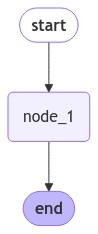

In [1]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.
 
So, it will just overwrite the value of `foo` in `node_1`: 

```
return {"foo": state['foo'] + 1}
```
 
If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

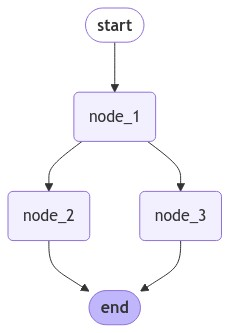

In [3]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---


We see a problem! 

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*. 

This is ambiguous for the graph! Which state should it keep? 

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

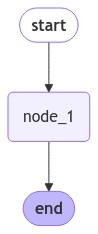

In [5]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list. 

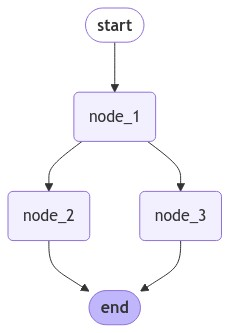

In [7]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [8]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

In [9]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [10]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

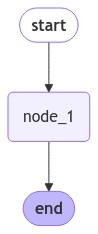

TypeError occurred: can only concatenate list (not "NoneType") to list


In [11]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

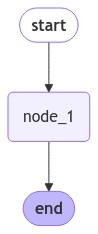

---Node 1---
{'foo': [2]}


In [12]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState` has a built-in `messages` key 
* It also has a built-in `add_messages` reducer for this key

These two are equivalent. 

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [29]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [13]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='f470d868-cf1b-45b2-ae16-48154cd55c12'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='a07a88c5-cb2a-4cbd-9485-5edb9d658366'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='7938e615-86c2-4cbb-944b-c9b2342dee68')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [14]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [15]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]


/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_17703/3097054180.py:10: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]


In [16]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

In [2]:
#Using TypeDict as our StateSchema

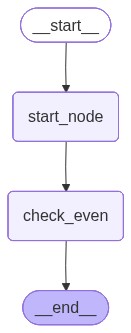

Start Node
Initial prime_2 value: 2
Check Even Node
4 is even.

Final State: {'prime_2': 4}


In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class PrimeState(TypedDict):
    prime_2: int  

def start_node(state: PrimeState):
    print(f"Start Node")
    print(f"Initial prime_2 value: {state['prime_2']}")
    return {"prime_2": state["prime_2"] * 2}

def check_even(state: PrimeState):
    print(f"Check Even Node")
    if state["prime_2"] % 2 == 0:
        print(f"{state['prime_2']} is even.")
    else:
        print(f"{state['prime_2']} is odd.")
    return {"prime_2": state["prime_2"]}

builder = StateGraph(PrimeState)

builder.add_node("start_node", start_node)
builder.add_node("check_even", check_even)

builder.add_edge(START, "start_node")
builder.add_edge("start_node", "check_even")
builder.add_edge("check_even", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

initial_state = {"prime_2": 2}
result = graph.invoke(initial_state)
print("\nFinal State:", result)


In [39]:
#Demonstrating Branching (This code demonstrates the problem with branching for the case when both add_item_a and add_tem_b try to update items

In [40]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown
from langgraph.errors import InvalidUpdateError

class CartState(TypedDict):
    items: int

def add_item_a(state):
    print("---Add Item A---")
    return {"items": state["items"] + 1}

def add_item_b(state):
    print("---Add Item B---")
    return {"items": state["items"] + 2}

builder = StateGraph(CartState)
builder.add_node("add_item_a", add_item_a)
builder.add_node("add_item_b", add_item_b)

builder.add_edge(START, "add_item_a")
builder.add_edge(START, "add_item_b")
builder.add_edge("add_item_a", END)
builder.add_edge("add_item_b", END)

graph = builder.compile()

mermaid_code = graph.get_graph().draw_mermaid()
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

try:
    graph.invoke({"items": 0})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


```mermaid
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	add_item_a(add_item_a)
	add_item_b(add_item_b)
	__end__([<p>__end__</p>]):::last
	__start__ --> add_item_a;
	__start__ --> add_item_b;
	add_item_a --> __end__;
	add_item_b --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

---Add Item A---
---Add Item B---
InvalidUpdateError occurred: At key 'items': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [42]:
#This demonstrate the way of fixing the problem using reducer


In [41]:
from typing import TypedDict, Annotated
from operator import add
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown

class CartState(TypedDict):
    items: Annotated[int, add]

def add_item_a(state):
    print("---Add Item A---")
    return {"items": 1}

def add_item_b(state):
    print("---Add Item B---")
    return {"items": 2}

builder = StateGraph(CartState)
builder.add_node("add_item_a", add_item_a)
builder.add_node("add_item_b", add_item_b)

builder.add_edge(START, "add_item_a")
builder.add_edge(START, "add_item_b")
builder.add_edge("add_item_a", END)
builder.add_edge("add_item_b", END)

graph = builder.compile()

mermaid_code = graph.get_graph().draw_mermaid()
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

result = graph.invoke({"items": 0})
print(result)

```mermaid
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	add_item_a(add_item_a)
	add_item_b(add_item_b)
	__end__([<p>__end__</p>]):::last
	__start__ --> add_item_a;
	__start__ --> add_item_b;
	add_item_a --> __end__;
	add_item_b --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

---Add Item A---
---Add Item B---
{'items': 3}


In [44]:
#This demonstrate the way of fixing the problem using custom reducers

In [43]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown

def add_items(existing, new):
    return existing + new

class CartState(TypedDict):
    items: Annotated[int, add_items]

def add_item_a(state):
    print("---Add Item A---")
    return {"items": 1}

def add_item_b(state):
    print("---Add Item B---")
    return {"items": 2}

builder = StateGraph(CartState)
builder.add_node("add_item_a", add_item_a)
builder.add_node("add_item_b", add_item_b)

builder.add_edge(START, "add_item_a")
builder.add_edge(START, "add_item_b")
builder.add_edge("add_item_a", END)
builder.add_edge("add_item_b", END)

graph = builder.compile()

mermaid_code = graph.get_graph().draw_mermaid()
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

result = graph.invoke({"items": 0})
print(result)

```mermaid
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	add_item_a(add_item_a)
	add_item_b(add_item_b)
	__end__([<p>__end__</p>]):::last
	__start__ --> add_item_a;
	__start__ --> add_item_b;
	add_item_a --> __end__;
	add_item_b --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

```

---Add Item A---
---Add Item B---
{'items': 3}


In [47]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(content="Hello! I can help you with coding questions.", name="Assistant"),
    HumanMessage(content="I want to learn Python loops.", name="Developer")
]

new_message = AIMessage(content="Great! Python has for loops and while loops. Which one would you like to start with?", name="Assistant")

updated_messages = add_messages(messages, new_message)
updated_messages

[AIMessage(content='Hello! I can help you with coding questions.', additional_kwargs={}, response_metadata={}, name='Assistant', id='7c59e348-39ba-42a2-b42a-e33bf6aeafa6'),
 HumanMessage(content='I want to learn Python loops.', additional_kwargs={}, response_metadata={}, name='Developer', id='4d0e99c1-5f6d-4e01-92e0-7998d4315851'),
 AIMessage(content='Great! Python has for loops and while loops. Which one would you like to start with?', additional_kwargs={}, response_metadata={}, name='Assistant', id='eaa456ed-4a7c-485e-8c64-f81d55a5284c')]

In [48]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(content="Hello! I can help you with coding questions.", name="Assistant", id="1"),
    HumanMessage(content="I want to learn Python loops.", name="Developer", id="2"),
    AIMessage(content="Great! Python has for loops and while loops. Which one would you like to start with?", name="Assistant", id="3")
]

new_message = AIMessage(content="Actually, Python also has list comprehensions which are very useful!", name="Assistant", id="3")

updated_messages = add_messages(messages, new_message)
updated_messages

[AIMessage(content='Hello! I can help you with coding questions.', additional_kwargs={}, response_metadata={}, name='Assistant', id='1'),
 HumanMessage(content='I want to learn Python loops.', additional_kwargs={}, response_metadata={}, name='Developer', id='2'),
 AIMessage(content='Actually, Python also has list comprehensions which are very useful!', additional_kwargs={}, response_metadata={}, name='Assistant', id='3')]

In [49]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage

messages = [
    AIMessage(content="Hello! I can help you with coding questions.", name="Assistant", id="1"),
    HumanMessage(content="I want to learn Python loops.", name="Developer", id="2"),
    AIMessage(content="Actually, Python also has list comprehensions which are very useful!", name="Assistant", id="3")
]

remove_message = RemoveMessage(id="2")

updated_messages = add_messages(messages, remove_message)
updated_messages


[AIMessage(content='Hello! I can help you with coding questions.', additional_kwargs={}, response_metadata={}, name='Assistant', id='1'),
 AIMessage(content='Actually, Python also has list comprehensions which are very useful!', additional_kwargs={}, response_metadata={}, name='Assistant', id='3')]